In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

Trying to get this to work again and understand everything after having been inactive for a while.

1. Install all the dependincies. - Done
2. Also installed graphviz
3. Understood `Class value` better

In [3]:
def f(x):
    return x * 3  + x **2

In [4]:
f(23)

598

In [5]:
f(3)

18

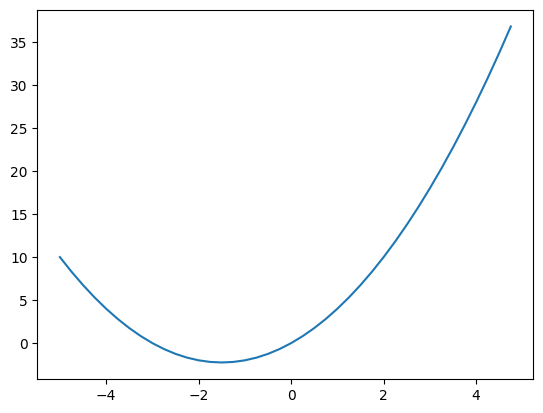

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Like this you can easily plot a function.

In [7]:
h = 0.0001
x = 3
(f(x+h) - f(x))/h

9.000100000022826

Taking a numerical derivative.

In [8]:
a = 2
b = -3
c = 10.0


d = a*b + c
print(d*2)

8.0


In [9]:
h = 0.0001
d1 = a*b + c
b +=h
d2 = a*b + c


print('slope', (d2 -d1)/h)

# All correct for now.

slope 2.0000000000042206


Understanding the Value class

In [10]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    

a = Value(2.0)

a

Value(data=2.0)

This simple skelleton can just store values but not do anything else. E.g. no addition.

You can create new methods in python using these __ __ methods. 

In [11]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

a = Value(2.0)

b = Value(3.0)

a + b 

Value(data=5.0)

This works well. We have added a new method.

If I edit this line

`out = Value(self.data + other.data)`

to have a $*$ instead of a $+$ then it multiplies the values, it's that easy. 


In [12]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad # Havn't understood this part yet ???
        out._backward = _backward

        return out

    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward


        return out
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(7.0, label = 'c')
d = a * b; d.label = 'd'
e = c * d; e.label = 'e'
e


Value(data=-42.0)

In [13]:
b.grad = 2.0

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Right now we can do multiplicaton and addition, but not much else yet.

Now we will learn to calculate the derivatives

In [15]:
def lol():

    hbig = Value(10000)
    hsmall = Value(0.0001)

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(6.0, label = 'c')
    d = Value(-9, label= 'e')
    e1 = a*b*c + d
    m = Value(-1)

    enormal = e1 * m; enormal.label = 'enormal'

    a = Value(2.0, label = 'a') 
    b = Value(-3.0, label = 'b')
    c = Value(6.0 + 0.0001, label = 'c')
    d = Value(-9, label= 'e')
    e2 = a*b*c + d
    
    
    
    r = (e2 + enormal) * hbig

    print(r)


    #Worked I did backpropagation correctly in this small model, the derivative -3.00000000 is correct.

In [16]:
lol()

Value(data=-5.9999999999860165)


In [17]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [18]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(7.0, label = 'c')
d = a * b; d.label = 'd'
e = c * d; e.label = 'e'

In [45]:
def lol2():

    h = 0.001

    a = Value(2.0,  label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(7.0+h,  label = 'c')
    d = a * b;  d.label = 'd'
    e = c * d;  e.label = 'e'

    e1 = e.data


    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(7.0, label = 'c')
    d = a * b; d.label = 'd'
    e = c * d; e.label = 'e'

    e2 = e.data
    
    
    
    r = (e1 - e2)/h

    print(r)

In [46]:
lol2()

-6.000000000000227


In [47]:
e.grad = 1

45 minuetse

In [48]:
a.grad = -21
b.grad = 14
c.grad = -6
d.grad = 7
e.grad = 1

In [49]:
print(o)

Value(data=0.9640275800758169)


In [51]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad


d = a * b;  d.label = 'd'
e = c * d;  e.label = 'e'


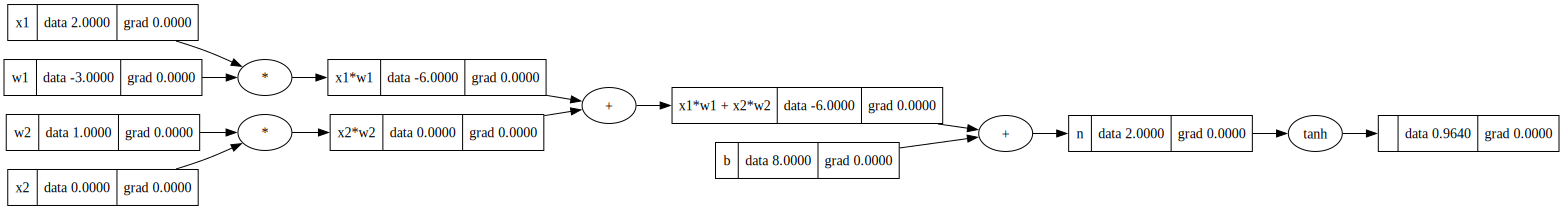

In [52]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(8, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

draw_dot(o)

In [61]:
print(o)

Value(data=0.7071067811865476)


In [64]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

Finished with all that stuff now will use Pytorch

This is at around 1:40

In [66]:
import torch

In [67]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [68]:
torch.Tensor([[1,2,3],[4,5,6],[1,2,3],[9,0,0]])

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [1., 2., 3.],
        [9., 0., 0.]])

In [69]:
x1.grad




tensor([-1.5000], dtype=torch.float64)

In [70]:
print('test')

test


In [71]:
x2.grad.item()

0.5000001283844369

In [72]:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    

    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x)for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]




class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    

In [73]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [5, 4, 5, 1])
n(x)

Value(data=-0.6335097898242352)

Making the Traning loop myself

In [74]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.2, 0.5],
  [0.5, 1.9, 1.0],
  [1.0, 1.8, -1.0],
  [-3.0, 3.3, 4.5],
  [-2.0, 1.0, 0.5],
  [1.4, 1.0, -4.4],
  [-3.5, -3.0, 0.5],
  [-2.7, 0.4, 0.5]
]
ys = [1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0] # desired targets


In [75]:
ypred = [n(x) for x in xs]
loss = sum((yout -ygt)**2  for ygt, yout in zip(ys, ypred))
print('The initial Loss is',loss.data)


for k in range(70):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout -ygt)**2  for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad

    if (k+1)%10 == 0:  print("The Loss of run",k+1,"is", loss.data)



The initial Loss is 14.246734025947076
The Loss of run 10 is 4.3698099139452715
The Loss of run 20 is 2.5433720131413073
The Loss of run 30 is 1.4843449246099114
The Loss of run 40 is 0.8298498001323126
The Loss of run 50 is 0.48197015120442854
The Loss of run 60 is 0.30431213258932754
The Loss of run 70 is 0.20851527974748163


In [76]:
ypred

[Value(data=0.8967356689527807),
 Value(data=-0.9690785657986762),
 Value(data=0.9054157028970252),
 Value(data=-0.9149360370891361),
 Value(data=0.8278340662482914),
 Value(data=-0.7383206472491594),
 Value(data=0.9516312494508615),
 Value(data=-0.8762195585224749),
 Value(data=0.7451760815377252)]

It worked

In [81]:
pic = draw_dot(n(x))

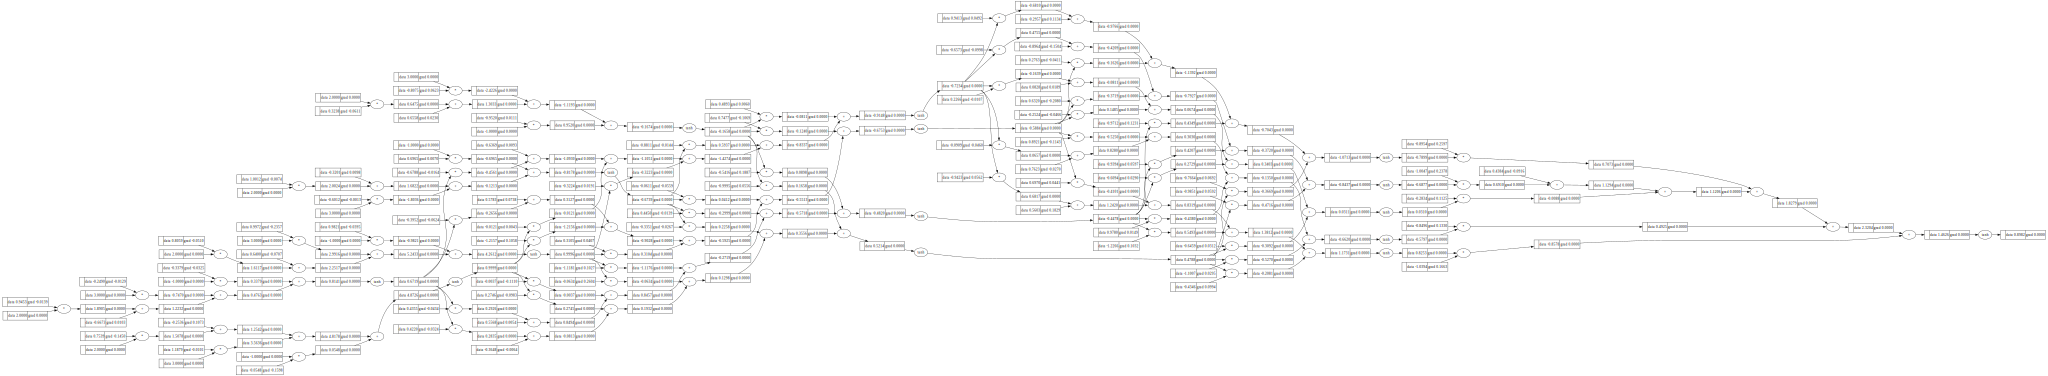

In [82]:
draw_dot(n(x))